<a href="https://colab.research.google.com/github/asminimulin/cv-course/blob/main/01-image-classification/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with KNN algorithm

## Install dependencies

## Mount the drive to store dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Define global constants which are never changed

In [2]:
class GlobalSettings:
  
  @property
  def PROJECT_DIR(self):
    return '/content/drive/MyDrive/cv-course/01-image-classification'

  @property
  def CLASS_NAMES(self):
    return ['Самолет', 'Автомобиль', 'Птица', 'Кошка', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

Global = GlobalSettings()

## Load the data

You can download CIFAR10 dataset from official site:

https://www.cs.toronto.edu/~kriz/cifar.html

or do it using Pytorch:
https://pytorch.org/vision/stable/datasets.html#cifar

or another framework.



In [3]:
import torch
import torchvision
train_ds = torchvision.datasets.CIFAR10(Global.PROJECT_DIR, train=True, download=False)
test_ds = torchvision.datasets.CIFAR10(Global.PROJECT_DIR, train=False)

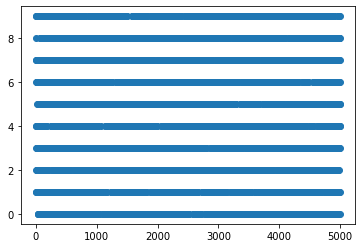

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter

x = np.arange(0, len(train_ds))
y = np.array(list(map(itemgetter(1), train_ds)))

fig, ax = plt.subplots()

ax.scatter(x[:5000], y[:5000])

plt.show()

In [5]:
from typing import Iterable, List, Tuple

import numpy as np
from PIL import Image


class Dataset:
  def __init__(self, train_ds: Iterable[Tuple[Image.Image, int]], test_ds: Iterable[Tuple[Image.Image, int]]):
    
    images = self.__get_images_array(train_ds)
    labels = self.__get_labels_array(train_ds)
    prediction_basis = [None] * len(Global.CLASS_NAMES)
    for i in range(len(prediction_basis)):
      prediction_basis[i] = images[labels == i]

    self.__train_images = np.array(prediction_basis)

    self.__test_images = self.__get_images_array(test_ds)[:500]
    self.__test_labels = self.__get_labels_array(test_ds)[:500]
    
  
  @property
  def validation(self) -> Tuple[np.array, np.array]:
    return self.__test_images, self.__test_labels


  @property
  def train(self) -> np.array:
    return self.__train_images


  @property
  def smoke_test(self) -> Tuple[np.array, np.array]:
    return self.__test_images[:10], self.__test_labels[:10]


  @staticmethod
  def __convert_image_to_array(image: Image.Image) -> np.array:
    assert 'RGB' == image.mode
    return np.array(list(image.tobytes()))


  @staticmethod
  def __get_images_array(ds: Iterable[Tuple[Image.Image, int]]) -> np.array:
    images = list(map(lambda x: Dataset.__convert_image_to_array(x[0]), ds))
    return np.array(images)


  @staticmethod
  def __get_labels_array(ds: Iterable[Tuple[Image.Image, int]]):
    labels = list(map(lambda item: item[1], ds))
    return np.array(labels)

dataset = Dataset(train_ds, test_ds)

## Split data into train and validation parts

Extract subset containing train and validation parts. 
Part must contain 5000 and 500 samples respectively.

In [6]:
print(f"Train dataset shape: {dataset.train.shape}")
print(f"Validation dataset len: {len(dataset.validation[0])}")


Train dataset shape: (10, 5000, 3072)
Validation dataset len: 500


## Dispaly some images  along with it class names
  


Самолет


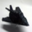

Автомобиль


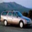

Птица


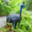

Кошка


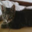

Олень


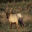

Собака


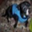

Лягушка


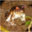

Лошадь


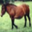

Корабль


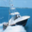

Грузовик


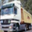

In [7]:
for i in range(len(Global.CLASS_NAMES)):
  for image, index in train_ds:
    if index == i:
      print(Global.CLASS_NAMES[i])
      display(image)
      break

# Implement NearestNeighbor class

In [8]:
from scipy import stats


class NearestNeighbor:
  def __init__(self, neighbors_num: int):
    self.__neighbors_num = neighbors_num


  def fit(self, train_images: np.array) -> None:
    """
      Arguments:
        train_images  iterable object of tuples of image and it's label
    """
    self.__prediction_basis = train_images

  
  def predict(self, images: np.array) -> np.array:
    """
      Arguments:
          images  (Tensor or numpy.array): collection of objects from testset (batch)
      
      Returns:
          class_num (Tensor or numpy.array) - collection of integer representing
          class numbers for objects from x             
    """
    return np.apply_along_axis(self.__predict_class, 1, images)


  __neighbours_num: int
  __prediction_basis: List[np.array]


  def __predict_class(self, image: np.array) -> int:
    distances = []
    for class_elements in self.__prediction_basis:
      selected_images = class_elements[np.random.randint(len(class_elements), size=self.__neighbors_num)]
      class_distances = np.apply_along_axis(lambda img: self._calculate_distance(image, img), 1, selected_images)
      distances.append(class_distances)
    distances_array = np.array(distances)
    nearest_neighbors = np.apply_along_axis(np.argmin, 0, distances_array)
    return stats.mode(nearest_neighbors)[0][0]


  def _calculate_distance(self, first_image: np.array, second_image: np.array) -> int:
    return ((second_image - first_image)**2).sum()

  @staticmethod
  def create_model(neighbors_num: int):
    return NearestNeighbor(neighbors_num)


##Perform smoke test

- Create model instance
- get predictions for dozen of samples


In [9]:
def run_smoke_test():
  model = NearestNeighbor(5)
  model.fit(dataset.train)

  images, labels = dataset.smoke_test
  predicted_labels = model.predict(images)
  accuracy = (predicted_labels == labels).sum() / len(labels)
  print(f"Accuracy of smoke test: {accuracy}")

In [10]:
run_smoke_test()

Accuracy of smoke test: 0.2


# Validate your model

## Create validation function

Must calculate Accuracy metric for your model.

In [11]:
def validate(model: NearestNeighbor, images: np.array, labels: np.array) -> float:
  """
      Arguments:
          model (Object): instance of NearestNeighbor class
          x (Tensor or numpy.array): collection of objects 
          y (Tensor or numpy.array): collection of integer representing
          class numbers for objects from x   
      
      Returns:
          accuracy (float) : percentage of correctly classified objects 
    """
  
  predicted_labels = model.predict(images)
  accuracy = (predicted_labels == labels).sum() / len(labels)
  
  return accuracy

 ## Calculate model accuracy on validation data

In [12]:
model = NearestNeighbor(20)
model.fit(dataset.train)
accuracy = validate(model, *dataset.validation)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.19


# Ideas for extra work

- Implenment K-NearestNeighbor
- Test different distance functions
- Find hyperparams using Cross-Validation
- Plot accuracy curve against K
- Evaluate time  

## Plot execution time and accuracy curve against K

In [13]:
def measure_model_performance(create_model_func, max_neighbors_num: int) -> Tuple[np.array, np.array, np.array]:
  from time import time
  neighbors_num_array = np.arange(1, max_neighbors_num + 1)
  execution_time_list = [0.0] * max_neighbors_num
  accuracy_list = [0.0] * max_neighbors_num

  for neighbors_num in range(1, max_neighbors_num + 1):
    model = create_model_func(neighbors_num)
    model.fit(dataset.train)
    start = time()
    accuracy = validate(model, *dataset.validation)
    end = time()
    execution_time = end - start
    execution_time_list[neighbors_num - 1] = execution_time
    accuracy_list[neighbors_num - 1] = accuracy

  return neighbors_num_array, np.array(accuracy_list), np.array(execution_time_list)

def draw_plots(neighbors_num_array: np.array, accuracy_array: np.array, execution_time_array: np.array):
  fig, ax = plt.subplots()
  ax.plot(neighbors_num_array, accuracy_array)

  ax.set_title("Accuracy against K")
  ax.set_xlabel("K")
  ax.set_ylabel("Accuracy")

  plt.show()

  fig, ax = plt.subplots()
  ax.plot(neighbors_num_array, execution_time_array)
  ax.set_title("Execution time against K")
  ax.set_xlabel("K")
  ax.set_ylabel("Execution time, seconds")

  plt.show()


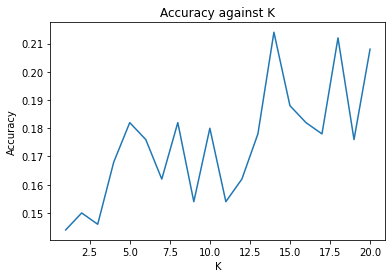

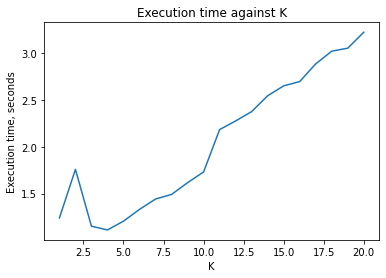

In [14]:
draw_plots(*measure_model_performance(NearestNeighbor.create_model, 20))

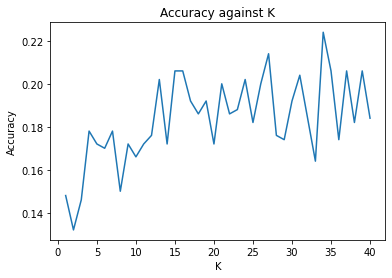

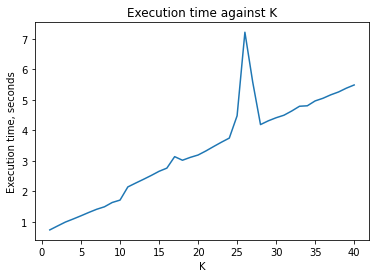

In [15]:
draw_plots(*measure_model_performance(NearestNeighbor.create_model, 40))

In [21]:
from scipy import stats


class NearestNeighborABS(NearestNeighbor):
  def __init__(self, neighbors_num):
    super().__init__(neighbors_num)

  def _calculate_distance(self, first_image: np.array, second_image: np.array) -> int:
    return (np.abs(second_image - first_image)).sum()

  @staticmethod
  def create_model(neighbors_num: int):
    return NearestNeighborABS(neighbors_num)


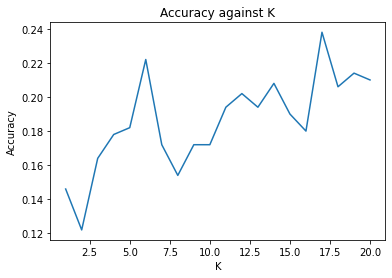

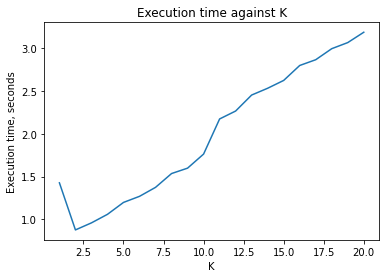

In [22]:
draw_plots(*measure_model_performance(NearestNeighborABS.create_model, 20))

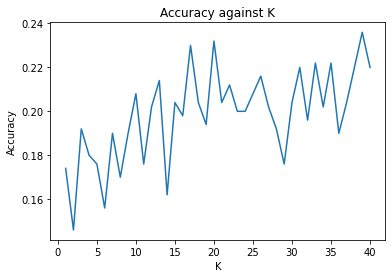

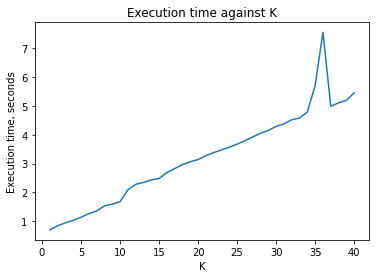

In [23]:
draw_plots(*measure_model_performance(NearestNeighborABS.create_model, 40))

In [27]:
model = NearestNeighborABS(20)
model.fit(dataset.train)
accuracy = validate(model, *dataset.validation)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.212


# Place for brief conclusion
Модель KNN позволяет решать задачу классификации изображений, где каждой отдельной фичей является отдельно взятая компонента одного пикселя лучше, чем константная модель.

Но качество модели все равно оставляет желать лучшего. Полученные результаты показывают, что модель может правильно классифицировать примерно одно из 5 изображений.



Увеличение K приводит к повышению качества модели, но это улучшение до K = 20 (в данном решении при K = 20 проверяется K*10 = 20 * 10 = 200 соседей), после чего не улучшается ни hit ration модели, ни стабильность.

Смена функции расстояния с расстояния в Евклидовом пространстве на модуль разности  координат точек приводит к улучшению. Как его численно оценить не понятно. Оно наблюдается только визуально на графиках. Максимальная точность в лучшем случае выше у второго варианта. Примерно половина значений accuracy в первом случае расположены в районе 0.18, в во втором - в районе 0.20.